# Milestone P3: Clustering using DBSCAN and its extension OPTICS

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import utils
# graphing
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# clustering
from sklearn.cluster import OPTICS, cluster_optics_dbscan

## Preprocessing of the data

In [2]:
DATA_PATH = Path.cwd() / "../data"
data = {
    Path(f).stem: pd.read_csv(f, index_col=0) for f in DATA_PATH.glob("combined_*.csv")
}
print(list(data.keys()))

['combined_metrics_finished_edges', 'combined_metrics_finished_paths', 'combined_metrics_unfinished_edges', 'combined_metrics_unfinished_paths']


In [3]:
features_finished_paths = data["combined_metrics_finished_paths"].reset_index(drop=True)
features_unfinished_paths = data["combined_metrics_unfinished_paths"].reset_index(
    drop=True
)
# drop timeout paths
features_unfinished_paths = features_unfinished_paths[features_unfinished_paths["type"] != "timeout"]
features_unfinished_paths


index   hashedIpAddress            timestamp  durationInSec  \
4          7  6d136e371e42474f  2011-02-07 18:07:50            175   
7         12  781192ee1a708bec  2011-02-08 03:46:15            334   
9         14  781192ee1a708bec  2011-02-08 03:55:46            403   
10        16  5900aa2d71b99153  2011-02-08 04:23:24            115   
13        19  2d49dfd2673786bf  2011-02-08 06:47:04            245   
...      ...               ...                  ...            ...   
18974  24867  109ed71f571d86e9  2014-01-15 11:01:43            152   
18975  24868  109ed71f571d86e9  2014-01-15 11:36:08             72   
18976  24869  109ed71f571d86e9  2014-01-15 12:00:12            182   
18977  24870  109ed71f571d86e9  2014-01-15 12:06:45            180   
18980  24874  1cf0cbb3281049ab  2014-01-15 21:54:01            352   

                                                    path  \
4      ['4-2-0', 'United_States', 'Agriculture', 'Sug...   
7      ['Saint_Kitts_and_Nevis', 'United_Kingdom', 'W...   
9      ['Symmetry', 'Science', 'Age_of_Enlightenment'...   
10     ['Tasmanian_Devil', 'Dog', 'Postage_stamp', 'W...   
13     ['Tim_Berners-Lee', 'England', 'Atlantic_Ocean...   
...                                                  ...   
18974  ['Montenegro', 'World_War_II', 'United_States'...   
18975        ['Wine', 'Georgia_%28country%29', 'Russia']   
18976  ['Turks_and_Caicos_Islands', 'United_States', ...   
18977  ['Franz_Kafka', 'Tuberculosis', 'World_Health_...   
18980  ['Mark_Antony', 'Rome', 'Tennis', 'Hawk-Eye', ...   

                              target     type  backtrack  numberOfPath  \
4                          Cane_Toad  restart          0         170.0   
7                       Sandy_Koufax  restart          0           1.0   
9          Scottish_Episcopal_Church  restart          0           3.0   
10                              Love  restart          0           1.0   
13                     Volcanic_pipe  restart          0           2.0   
...                              ...      ...        ...           ...   
18974              Hurricane_Georges  restart          0          20.0   
18975  History_of_post-Soviet_Russia  restart          0          27.0   
18976                       Iraq_War  restart          0          35.0   
18977                        Cholera  restart          1          37.0   
18980                        Feather  restart          0          49.0   

       path_length  ...  ratio  average_time_on_page  \
4                5  ...      3             35.000000   
7                5  ...      3             66.800000   
9                6  ...      1             67.166667   
10               4  ...      3             28.750000   
13               6  ...      3             40.833333   
...            ...  ...    ...                   ...   
18974            7  ...      4             21.714286   
18975            3  ...      2             24.000000   
18976            6  ...      2             30.333333   
18977            6  ...      3             30.000000   
18980            5  ...      2             70.400000   

                                         sucessive_pairs  \
4      [('4-2-0', 'United_States'), ('United_States',...   
7      [('Saint_Kitts_and_Nevis', 'United_Kingdom'), ...   
9      [('Symmetry', 'Science'), ('Science', 'Age_of_...   
10     [('Tasmanian_Devil', 'Dog'), ('Dog', 'Postage_...   
13     [('Tim_Berners-Lee', 'England'), ('England', '...   
...                                                  ...   
18974  [('Montenegro', 'World_War_II'), ('World_War_I...   
18975  [('Wine', 'Georgia_%28country%29'), ('Georgia_...   
18976  [('Turks_and_Caicos_Islands', 'United_States')...   
18977  [('Franz_Kafka', 'Tuberculosis'), ('Tuberculos...   
18980  [('Mark_Antony', 'Rome'), ('Rome', 'Tennis'), ...   

                                 sucessive_pairs_encoded  semantic_similarity  \
4      [0.19640377163887024, 0.2371780127286911, 0.32...             0.245052   


In [4]:
combined_df = pd.concat([features_finished_paths, features_unfinished_paths], axis=0)
combined_df['finished'] = [1] * len(features_finished_paths) + [0] * len(features_unfinished_paths)
combined_df[utils.FEATURES_COLS_USED_FOR_CLUSTERING] = utils.normalize_features(combined_df[utils.FEATURES_COLS_USED_FOR_CLUSTERING])

In [5]:
X = combined_df[utils.FEATURES_COLS_USED_FOR_CLUSTERING].copy().values
#find number of NaNs in each column
nans = np.isnan(X).sum(axis=0)
print(nans)
#drop rows with NaNs
X = X[~np.isnan(X).any(axis=1)]

[0 0 3 0 0 0 0 0 0 0]


### Let's find the dimensionality of the data

Text(0, 0.5, 'explained variance')

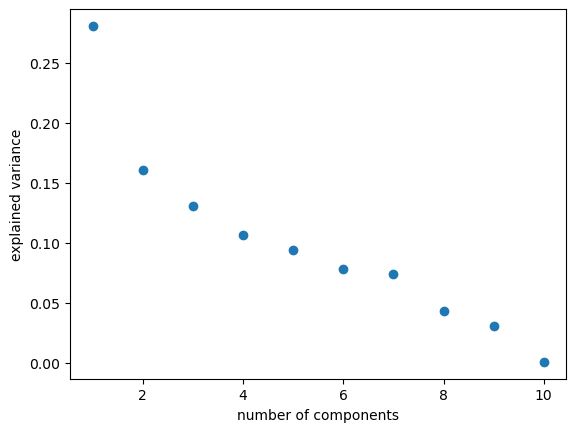

In [6]:
#find the dimensionality of the data
from sklearn.decomposition import PCA
pca = PCA(n_components=X.shape[1])
pca.fit(X)
# plot the explained variance
plt.scatter(range(1,X.shape[1]+1), pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance')


We will keep only the 7 first dimensions

## Clustering

### We will run optics on a lower dimension to avoid the curse of the dimensionality 

#### Let's find the latent space using a UMAP

In [7]:
from umap import umap_ as UMAP
# UMAP
umap = UMAP.UMAP(n_components=7, metric="euclidean")
result_umap_euc = umap.fit_transform(
    X
)

#### Run the clustering in this space using OPTICS or fixed cutoff values with DBSCAN

In [8]:
#code taken from https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html
clust = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05)

# Run the fit
clust.fit(result_umap_euc)

labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=2,
)


#### Visualize the results in the plan defined by the 2 first features and draw a reachability plot

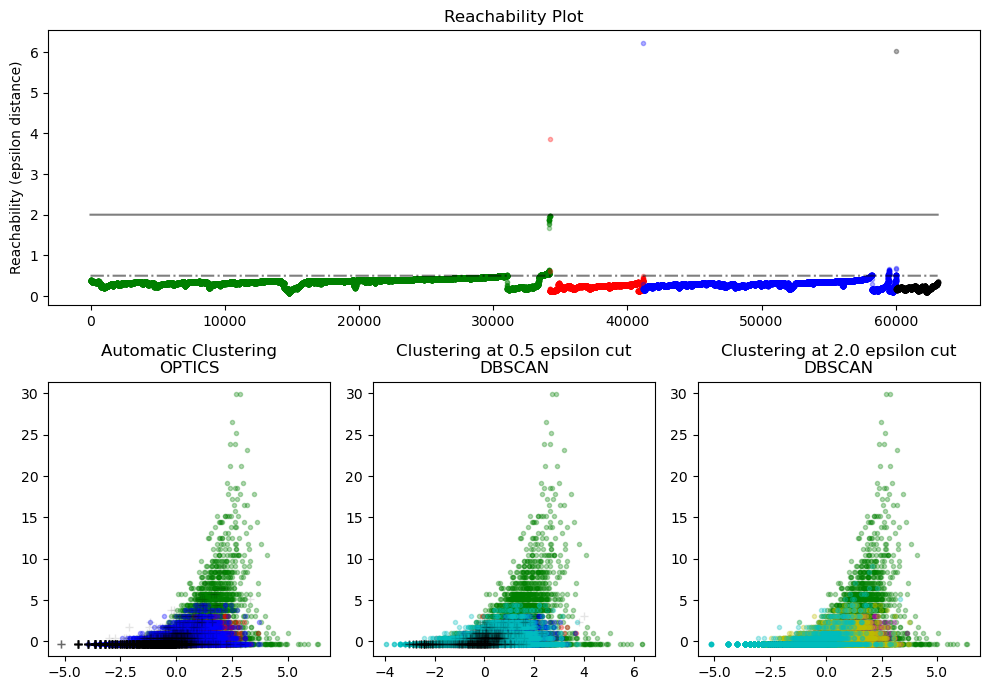

In [9]:
space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# OPTICS
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.5
colors = ["g.", "r.", "b.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

### Create a UMAP with 3 dimensions for visualization purposes

In [10]:
from umap import umap_ as UMAP
# UMAP
umap = UMAP.UMAP(n_components=3, metric="euclidean")
result_umap_euc = umap.fit_transform(
    X
)

In [11]:
import plotly.express as px
fig = px.scatter_3d(
    result_umap_euc,
    x=0,
    y=1,
    z=2,
    color=clust.labels_.astype(str),
    title="UMAP, clustering by OPTICS",
    #reduce size points
    size_max=0.1,
)
fig.show()

By providing a UMAP in 7 dimension to OPTICS we roughly find the communities that we can see by eye in the 3D UMAP

### Visualization of the results

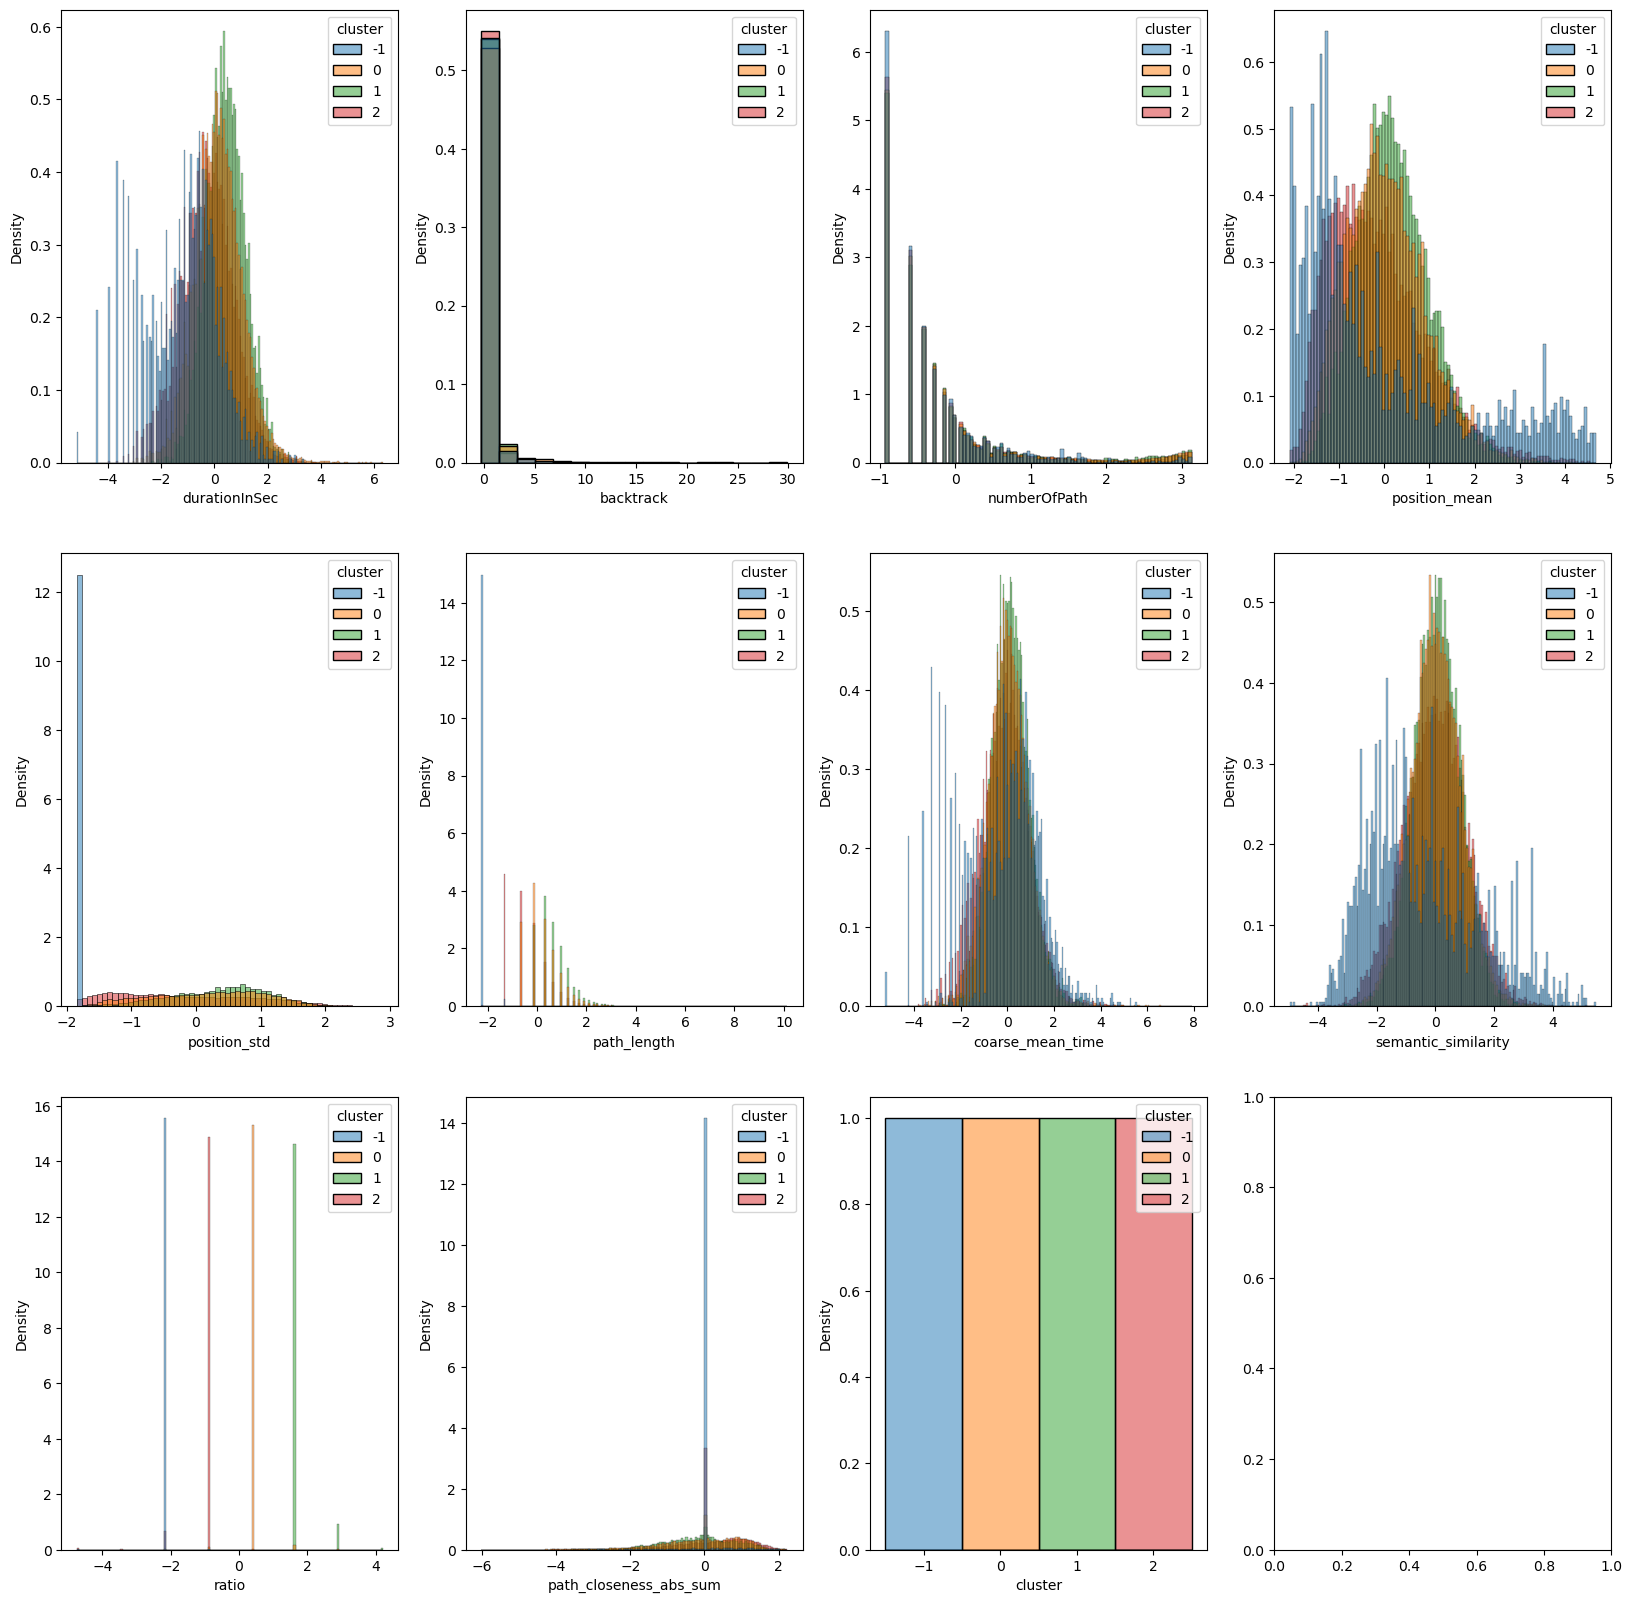

In [12]:
#plot histogram features colored by cluster
plot_data = combined_df[utils.FEATURES_COLS_USED_FOR_CLUSTERING].copy().dropna()
plot_data["cluster"] = clust.labels_
plot_data["cluster"] = plot_data["cluster"].astype("category")
n_features = len(plot_data.columns)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
axs = axs.flatten()
for i, col in enumerate(plot_data.columns):
    sns.histplot(
        data=plot_data,
        x=col,
        hue="cluster",
        ax=axs[i],
        stat="density",
        common_norm=False,
    )

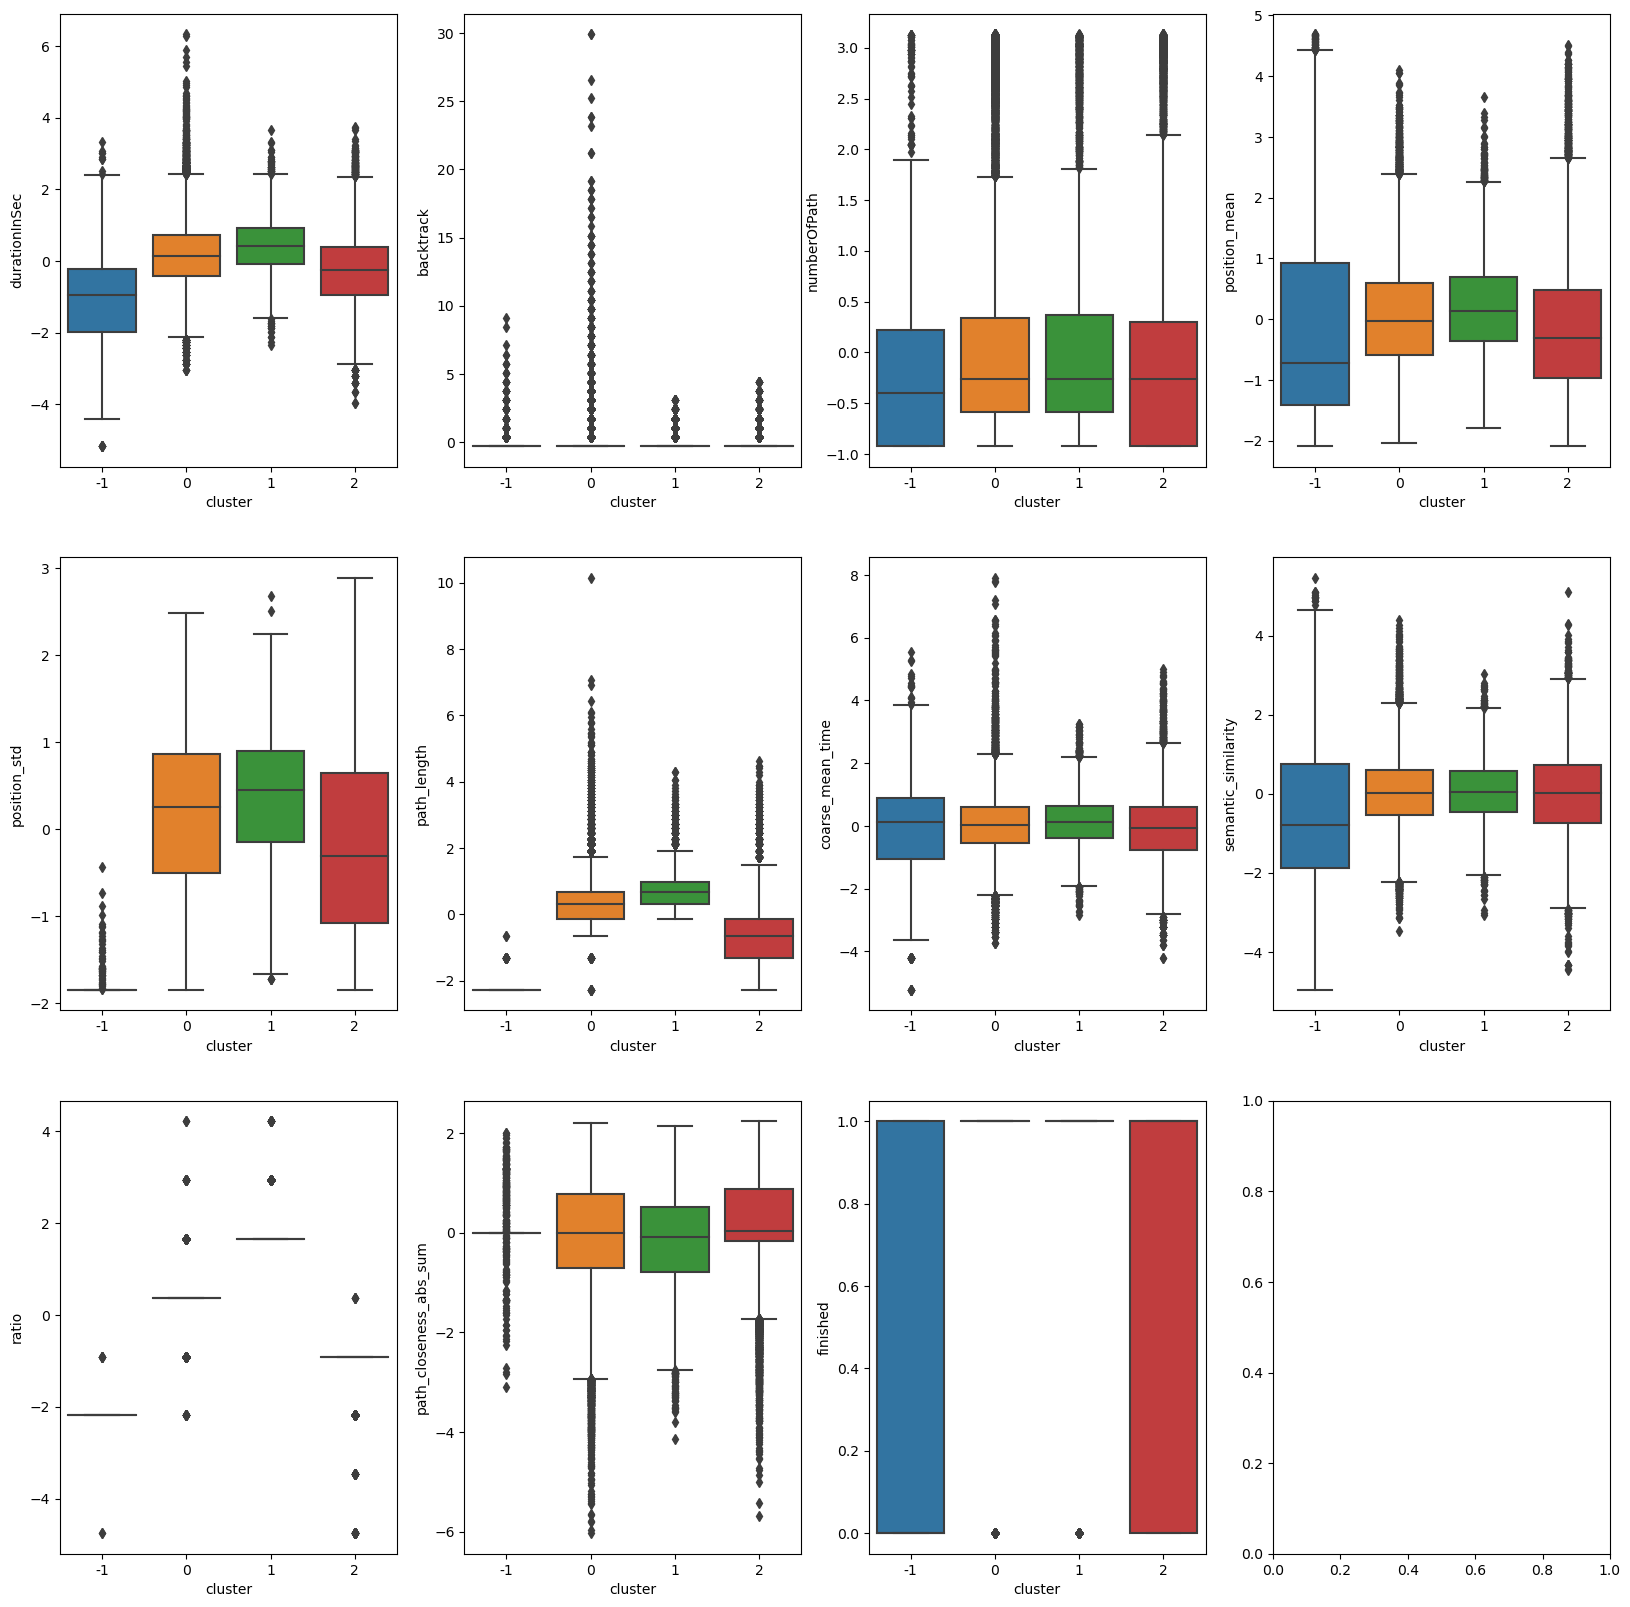

In [13]:
#plot the boxplots of features colored by cluster
plot_data = combined_df[utils.FEATURES_COLS_USED_FOR_CLUSTERING+["finished"]].copy().dropna()
plot_data["cluster"] = clust.labels_
plot_data["cluster"] = plot_data["cluster"].astype("category")
n_features = len(plot_data.columns)-1
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
axs = axs.flatten()
for i, col in enumerate(plot_data.columns):
    if col != "cluster":
        sns.boxplot(data=plot_data, x="cluster", y=col, ax=axs[i])

<Axes: ylabel='cluster'>

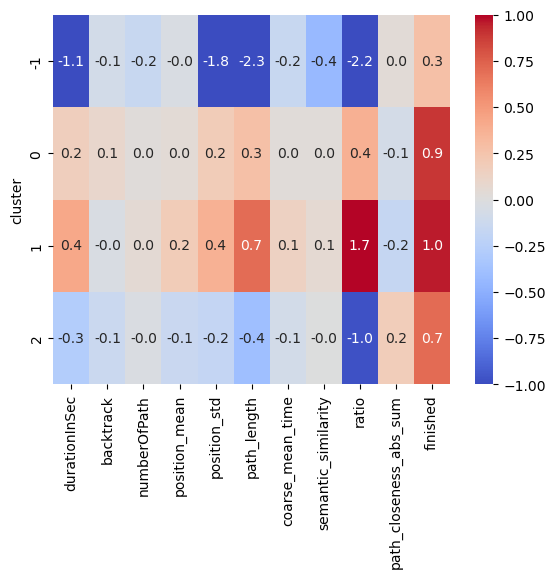

In [14]:
# heatmap of features means per cluster
means = plot_data.groupby(plot_data["cluster"]).mean()
sns.heatmap(means, cmap="coolwarm", annot=True, fmt=".1f", vmin=-1, vmax=1)

Here we can see that the clustering is less interesting. It really makes 4 clusters in which all the features used to do the clustering are either very low, low, high or very high.